# **Part A**
Count / Frequency based Naive Bayes Classifier

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# Data loading function (DO NOT CHANGE)
# =======================================================
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# =======================================================
# Implementing Multinomial Naive Bayes from scratch
# =======================================================
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # ✅ Calculate the log prior and store it in self.class_priors[c]
            # log(P(C)) = log(#samples_in_class / total_samples)
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # ✅ Apply Laplace smoothing (additive smoothing)
            numerator = feature_sum + self.alpha
            denominator = total_mass + self.alpha * self.vocabulary_size

            # ✅ Calculate log likelihood (log(numerator / denominator))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # ✅ Add log likelihood contribution (Log-Sum Trick)
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            # ✅ Find class with maximum score
            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        # ✅ Return final predictions as numpy array
        return np.array(y_pred)


In [17]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    # Remove placeholder data
    # train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [18]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 1),
        min_df=5
    )

    print("Fitting Count Vectorizer and transforming training data...")
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    nb_model = NaiveBayesClassifier(alpha=1.0)

    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")

Fitting Count Vectorizer and transforming training data...
Vocabulary size: 22722
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [19]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")


=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7337
              precision    recall  f1-score   support

  BACKGROUND       0.52      0.56      0.54      3621
 CONCLUSIONS       0.60      0.66      0.63      4571
     METHODS       0.82      0.84      0.83      9897
   OBJECTIVE       0.50      0.51      0.51      2333
     RESULTS       0.87      0.78      0.82      9713

    accuracy                           0.73     30135
   macro avg       0.66      0.67      0.67     30135
weighted avg       0.74      0.73      0.74     30135

Macro-averaged F1 score: 0.6655


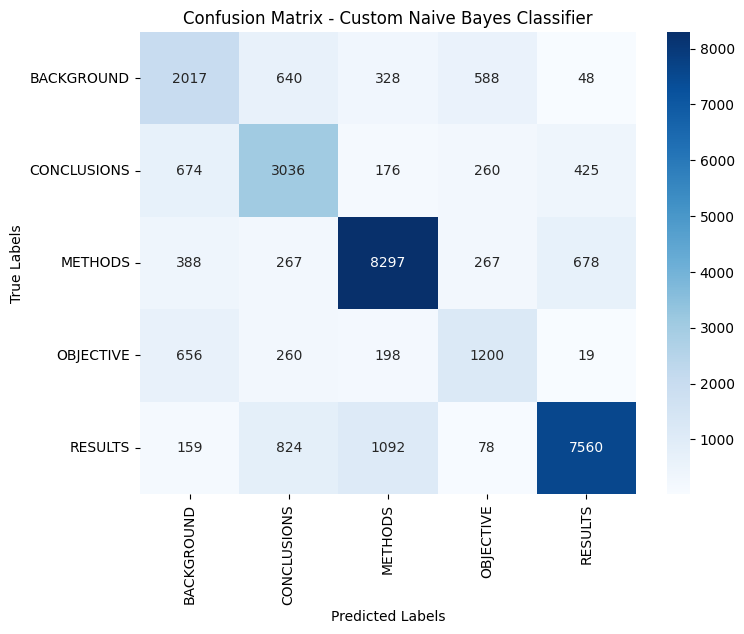

In [20]:
# =======================================================
# Confusion Matrix on test set
# =======================================================

# Ensure y_test_pred (or y_pred) exists before plotting
if 'y_test_pred' in locals() and y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - Custom Naive Bayes Classifier')
    plt.show()
else:
    print("⚠️ Please run prediction cell first to get y_test_pred.")

# **Part B**
TF-IDF score based Classifier

Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7266
              precision    recall  f1-score   support

  BACKGROUND       0.64      0.43      0.51      3621
 CONCLUSIONS       0.62      0.61      0.62      4571
     METHODS       0.72      0.90      0.80      9897
   OBJECTIVE       0.73      0.10      0.18      2333
     RESULTS       0.80      0.87      0.83      9713

    accuracy                           0.73     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.72      0.73      0.70     30135

Macro-averaged F1 score: 0.5877

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Grid search complete.

=== Best Parameters and Score (from Grid Search) ===
Best Parameters: {'nb__alpha': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Macro F1 Score: 0.6948

=== Evaluation of Best Tun

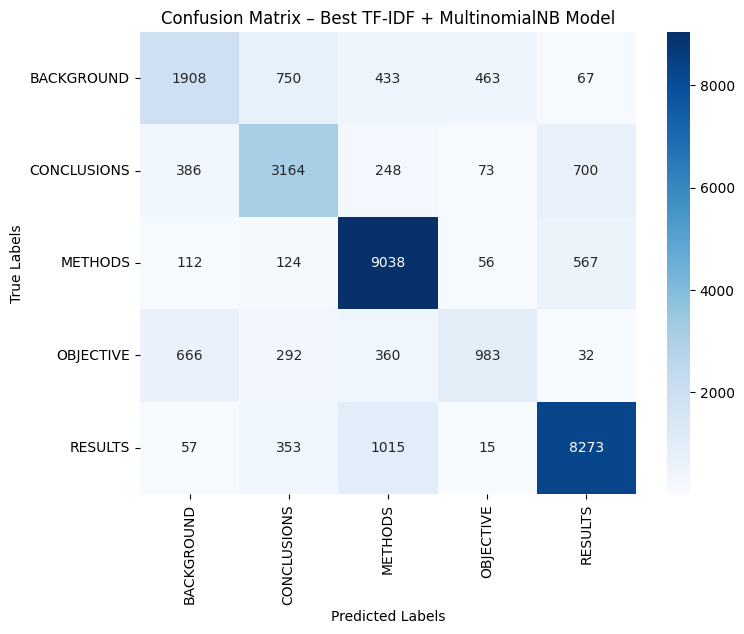

In [21]:
# =======================================================
# TF-IDF Score Based Classifier  (Part B)
# =======================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# Steps:
# 1. Define a Pipeline (TfidfVectorizer + MultinomialNB)
# 2. Train initial pipeline on (X_train, y_train)
# 3. Evaluate on test data
# 4. Define param_grid for hyperparameter tuning
# 5. Run GridSearchCV (cv=3, scoring='f1_macro') on dev data
# 6. Print best params and best score
# =======================================================


# 1️⃣ Define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),      # default settings initially
    ('nb', MultinomialNB())            # default alpha=1.0
])

# 2️⃣ Train the initial pipeline on training data
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")

# 3️⃣ Predict and evaluate on test set
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)

# Determine unique class labels (target names)
target_names = sorted(np.unique(y_test))

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")

# 4️⃣ Define parameter grid for hyperparameter tuning
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],    # unigrams vs bigrams
    'tfidf__min_df': [1, 2],                   # ignore rare words
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]          # Laplace smoothing
}

# 5️⃣ Initialize GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

# 6️⃣ Fit Grid Search on development data (per lab instructions)
print("\nStarting Hyperparameter Tuning on Development Set...")
grid.fit(X_dev, y_dev)
print("Grid search complete.")

# 7️⃣ Print best parameters and score
print("\n=== Best Parameters and Score (from Grid Search) ===")
print("Best Parameters:", grid.best_params_)
print(f"Best Cross-Validation Macro F1 Score: {grid.best_score_:.4f}")

# 8️⃣ Evaluate the best model on the test set
best_model = grid.best_estimator_
y_test_best = best_model.predict(X_test)

print("\n=== Evaluation of Best Tuned Model on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, y_test_best):.4f}")
print(f"Macro F1: {f1_score(y_test, y_test_best, average='macro'):.4f}")
print(classification_report(y_test, y_test_best, target_names=target_names))

# Optional: Confusion Matrix for the best model
cm = confusion_matrix(y_test, y_test_best, labels=target_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix – Best TF-IDF + MultinomialNB Model")
plt.show()


# **Part C**
Bayes Optimal Classifier

Part C Draft

Please enter your full SRN (e.g., PES2UG23CSxxx): PES2UG23CS364
Using dynamic sample size: 10364
Actual sampled training set size used: 10364

Training all base models...
Training NaiveBayes...
Training LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training RandomForest...
Training DecisionTree...
Training KNN...
✅ All base models trained successfully!

Calculating posterior weights...
NaiveBayes Validation Macro F1: 0.7828
LogisticRegression Validation Macro F1: 0.7586
RandomForest Validation Macro F1: 0.5734
DecisionTree Validation Macro F1: 0.2890
KNN Validation Macro F1: 0.3152
Posterior Weights (normalized): [0.2878951880806323, 0.27899777576760537, 0.21089084993946944, 0.1062987936451271, 0.11591739256716574]

Fitting the VotingClassifier (BOC approximation)...
✅ Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7034
Macro F1-score: 0.6050
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.35      0.43      3621
 CONCLUSIONS       0.60      0.54      0.57      4571
     METHODS       0.70      0.89      0.78      9897
   OBJECTIVE       0.66      0.33      0.44      2333
     RESULTS       0.79      0.81      0.80    

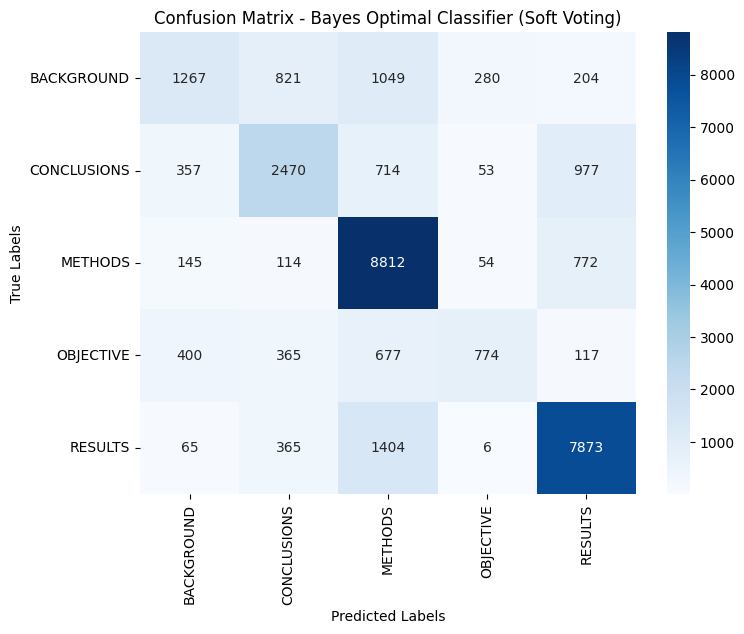

In [23]:
# =======================================================
# Bayes Optimal Classifier (BOC)
# =======================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split  # Used for P(h|D) calculation

# =======================================================
# TODO: Implement the following steps:
# 1. Train all five hypotheses on the sampled training data.
# 2. Compute the Posterior Weights P(h_i | D) using a validation split.
# 3. Fit the VotingClassifier using the sampled training data.
# 4. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000

FULL_SRN = input("Please enter your full SRN (e.g., PES2UG23CSxxx): ")

try:
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    print("WARNING: SRN input failed or format is incorrect. Using default 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Ensure data exists (fallback)
if 'X_train' not in locals() or len(X_train) == 0:
    print("⚠️ Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

# =======================================================
# Define Base Hypotheses
# =======================================================

tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

# H1: Multinomial Naive Bayes
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

# H2: Logistic Regression
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

# H3: Random Forest
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])

# H4: Decision Tree
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

# H5: K-Nearest Neighbors
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

# =======================================================
# Train All Models
# =======================================================
print("\nTraining all base models...")
for model, name in zip(hypotheses, hypothesis_names):
    print(f"Training {name}...")
    model.fit(X_train_sampled, y_train_sampled)
print("✅ All base models trained successfully!")

# =======================================================
# Posterior Weight Calculation P(h_i | D)
# =======================================================
print("\nCalculating posterior weights...")

# Split training data into sub-train and validation for posterior weighting
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42
)

val_scores = []
for model, name in zip(hypotheses, hypothesis_names):
    y_val_pred = model.predict(X_val_sub)
    score = f1_score(y_val_sub, y_val_pred, average='macro')
    val_scores.append(score)
    print(f"{name} Validation Macro F1: {score:.4f}")

# Normalize to get posterior weights
posterior_weights = np.array(val_scores) / np.sum(val_scores)
posterior_weights = posterior_weights.tolist()
print(f"Posterior Weights (normalized): {posterior_weights}")

# =======================================================
# Bayes Optimal Classifier via Soft Voting
# =======================================================
estimators = list(zip(hypothesis_names, hypotheses))

boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("✅ Fitting complete.")

# =======================================================
# Final Evaluation
# =======================================================
print("\nPredicting on test set...")
y_pred = boc_soft_voter.predict(X_test)

print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Macro F1-score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(classification_report(y_test, y_pred, target_names=np.unique(y_test)))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Bayes Optimal Classifier (Soft Voting)')
plt.show()
